# Import Libraries

In [1]:
!pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 20.7 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [2]:
!apt install libspatialindex-dev
!pip install rtree
!pip install geopandas



Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 4 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 2s (223 kB/s)
Selecting previously unselected package libspatialindex4

In [3]:
import math
import pandas as pd
import numpy as np
from dateutil import relativedelta

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import geopandas as gpd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

# Loading Data

In [4]:
url = 'https://raw.githubusercontent.com/iamamofa/dataset-shona/main/shona.csv'
dataset = pd.read_csv(url)

In [5]:
dataset.head

<bound method NDFrame.head of            lat       lng    zip  \
0     5.635828 -0.161359  233.0   
1     5.644369 -0.185427  233.0   
2     5.633940 -0.174082  233.0   
3     5.651038 -0.135459  233.0   
4     5.652202 -0.188107  233.0   
...        ...       ...    ...   
3028  6.166068 -1.141299  233.0   
3029  5.529817 -0.705779  233.0   
3030  5.529817 -0.705779  233.0   
3031  5.569648 -0.287579  233.0   
3032  6.702649 -1.604459  233.0   

                                                 desc  \
0           East Legon, Accra, Ghana,11/10/2015@15:20   
1        Noguchie Link, Accra, Ghana,11/10/2015@17:35   
2             Shiashie, Accra, Ghana,11/10/2015@14:39   
3        Adjiringanor, Madina, Ghana,11/10/2015@16:47   
4     W.E.B. Dubois Rd, Accra, Ghana,11/10/2015@16:56   
...                                               ...   
3028                   Ofoase, Ghana,04/03/2016@15:24   
3029             Agona Swedru, Ghana,04/03/2016@15:30   
3030             Agona Swedru, Ghana



---



# Data Understanding and Cleaning

In [6]:
dataset.shape

(3033, 9)

**Observations**


*  Dataset comprises of 3033 observations and 9 fields.




In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3033 entries, 0 to 3032
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lat        3033 non-null   float64
 1   lng        3033 non-null   float64
 2   zip        3023 non-null   float64
 3   desc       3033 non-null   object 
 4   title      3033 non-null   object 
 5   timeStamp  3033 non-null   object 
 6   twp        2390 non-null   object 
 7   addr       3032 non-null   object 
 8   e          3033 non-null   int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 213.4+ KB


**Observations**

*   Data has float, integer, and object type values.

*   Data type of timeStamp is object that need to convert to datetime.





In [8]:
dataset.columns

Index(['lat', 'lng', 'zip', 'desc', 'title', 'timeStamp', 'twp', 'addr', 'e'], dtype='object')

**Observations**

The data contains the following fields:
* lat : String variable, Latitude
* lng: String variable, Longitude
* desc: String variable, Description of the Emergency Call
* zip: String variable, Zipcode
* title: String variable, Title
* timeStamp: String variable, YYYY-MM-DD HH:MM:SS
* twp: String variable, Township
* addr: String variable, Address
* e: String variable, Dummy variable (always 1)



In [9]:
dataset.drop('e', axis=1, inplace=True)

In [10]:
type(dataset['timeStamp'].iloc[1])

str

In [11]:
dataset['timeStamp'] = pd.to_datetime(dataset['timeStamp'])

mindate = dataset["timeStamp"].min()
maxdate = dataset["timeStamp"].max()
dif = relativedelta.relativedelta(pd.to_datetime(maxdate), pd.to_datetime(mindate))
print("{} years and {} months".format(dif.years, dif.months))



0 years and 4 months


**Observations**

* So in a 4 years and 7 months of time span from Dec 2015 to April 2020, about 6.3 hundred people called emergency number 911 to get help in Montgomery County, PA.

In [12]:
dataset['Hour'] = dataset['timeStamp'].apply(lambda time: time.hour)

dataset['Day'] = dataset['timeStamp'].apply(lambda time: time.dayofweek)
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
dataset['Day'] = dataset['Day'].map(dmap)


dataset['Month'] = dataset['timeStamp'].apply(lambda time: time.month)
dmap = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
dataset['Month'] = dataset['Month'].map(dmap)

dataset['Year'] = dataset['timeStamp'].apply(lambda time: time.year)

dataset['Date'] = dataset['timeStamp'].apply(lambda time:time.date())



---



### 'desc' field : Description of the Emergency Call

'desc' field contains three information, Address, Township and Station code seperated by semi-column. So lets seperate them out to get the station code, to which the call has been made and drop the 'desc' field.


In [13]:
dataset['station_code']=dataset['desc'].str.split('Station', expand=True)[1].str.split(';', expand=True)[0]
dataset['station_code'] = dataset['station_code'].str.replace(':', '')
dataset['station_code']= dataset['station_code'].str.strip()
dataset['station_code'].head(10)

dataset.drop(['desc'], axis=1, inplace=True)

In the titles column there are "Reasons/Departments" specified before the title code. These are EMS, Fire, and Traffic. So lets split into Type and Reason.

In [14]:
dataset['Type'] = dataset["title"].apply(lambda x: x.split(':')[0])
dataset['Reason'] = dataset["title"].apply(lambda x: x.split(':')[1])



---



# Exploratory Data Analysis (EDA)

In [15]:
dataset["Type"].value_counts()

EMS        1481
Traffic    1148
Fire        404
Name: Type, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


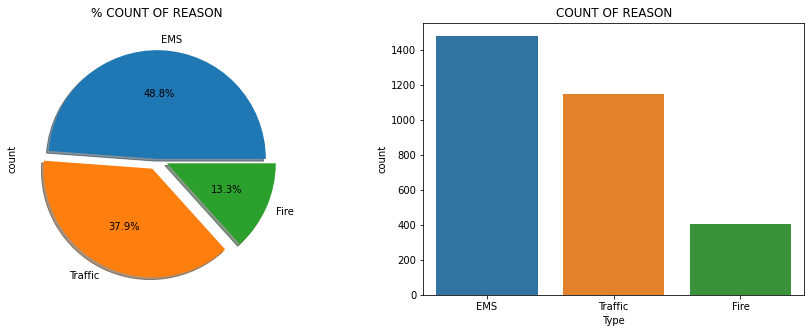

In [16]:
f,ax=plt.subplots(1,2,figsize=(15,5))
dataset['Type'].value_counts().plot.pie(explode=[0,0.1,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('% COUNT OF REASON')
ax[0].set_ylabel('count')
sns.countplot('Type',data=dataset,ax=ax[1],order=dataset['Type'].value_counts().index)
ax[1].set_title('COUNT OF REASON')
plt.show()

**Observations**

* The number one reason for 911 calls are Emergency Medical Services (EMS).
* Almost half of the reasons are for EMS.

In [17]:
dataset["title"].value_counts()

Traffic: VEHICLE ACCIDENT -    844
Traffic: DISABLED VEHICLE -    181
EMS: CARDIAC EMERGENCY         165
EMS: RESPIRATORY EMERGENCY     156
Fire: FIRE ALARM               153
                              ... 
EMS: FIRE SPECIAL SERVICE        1
EMS: WARRANT SERVICE             1
EMS: BURN VICTIM                 1
Fire: BURN VICTIM                1
EMS: ANIMAL BITE                 1
Name: title, Length: 76, dtype: int64

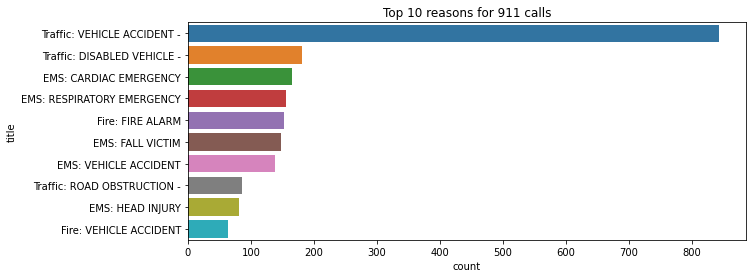

In [18]:
fig,ax=plt.subplots(figsize=(10,4))
sns.countplot(y='title',data=dataset,order=dataset['title'].value_counts().head(10).index)
plt.title('Top 10 reasons for 911 calls')
plt.show()

**Observations**

The bar chart shows top 10 reason for 911 calls.
* Vehicle accidents are the number one reason people call 911.
* Disabled vehicle and fire alarm are in second and third place.



---



#### Traffic 911 Emergency Calls

In [19]:
traffic=dataset[dataset['Type']=='Traffic']
traffic['Reason'].value_counts()

 VEHICLE ACCIDENT -             844
 DISABLED VEHICLE -             181
 ROAD OBSTRUCTION -              86
 HAZARDOUS ROAD CONDITIONS -     17
 VEHICLE FIRE -                  16
 DEBRIS/FLUIDS ON HIGHWAY -       2
 VEHICLE LEAKING FUEL -           2
Name: Reason, dtype: int64

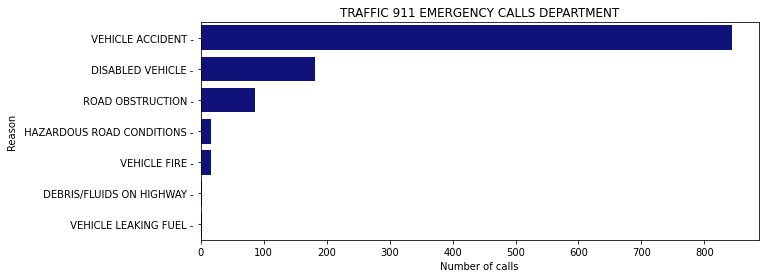

In [20]:
fig,ax=plt.subplots(figsize=(10,4))
sns.countplot(y='Reason',data=traffic,order=traffic['Reason'].value_counts().head(7).index, color='darkblue')
ax.set_xlabel('Number of calls')
plt.title('TRAFFIC 911 EMERGENCY CALLS DEPARTMENT')
plt.show()

**Observations**

* The most common emergency titles are vehicle accident, disable vehicle and road obstruction.


---



#### Fire 911 Emergency Calls

In [21]:
fire=dataset[dataset['Type']=='Fire']
fire['Reason'].value_counts()

 FIRE ALARM                   153
 VEHICLE ACCIDENT              63
 GAS-ODOR/LEAK                 38
 FIRE INVESTIGATION            24
 BUILDING FIRE                 22
 CARBON MONOXIDE DETECTOR      20
 VEHICLE FIRE                  15
 ELECTRICAL FIRE OUTSIDE       13
 UNKNOWN TYPE FIRE             12
 TRASH/DUMPSTER FIRE            8
 FIRE SPECIAL SERVICE           6
 S/B AT HELICOPTER LANDING      5
 APPLIANCE FIRE                 5
 WOODS/FIELD FIRE               4
 DEBRIS/FLUIDS ON HIGHWAY       4
 RESCUE - GENERAL               3
 FIRE POLICE NEEDED             2
 RESCUE - ELEVATOR              2
 BURN VICTIM                    1
 PUMP DETAIL                    1
 TRANSFERRED CALL               1
 RESCUE - TECHNICAL             1
 VEHICLE LEAKING FUEL           1
Name: Reason, dtype: int64

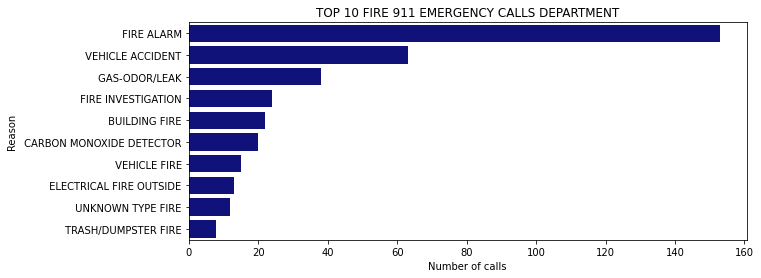

In [22]:
fig,ax=plt.subplots(figsize=(10,4))
sns.countplot(y='Reason',data=fire,order=fire['Reason'].value_counts().head(10).index, color='darkblue')
ax.set_xlabel('Number of calls')
plt.title('TOP 10 FIRE 911 EMERGENCY CALLS DEPARTMENT')
plt.show()

**Observation**

* The most common emergency titles are fire alarm, vehicle accident and fire investigation.



---



#### EMS 911 Emergency Calls

In [23]:
EMS=dataset[dataset['Type']=='EMS']
EMS['Reason'].value_counts()

 CARDIAC EMERGENCY            165
 RESPIRATORY EMERGENCY        156
 FALL VICTIM                  147
 VEHICLE ACCIDENT             139
 HEAD INJURY                   81
 SUBJECT IN PAIN               60
 UNKNOWN MEDICAL EMERGENCY     57
 SYNCOPAL EPISODE              52
 SEIZURES                      44
 ABDOMINAL PAINS               44
 GENERAL WEAKNESS              44
 ALTERED MENTAL STATUS         41
 UNCONSCIOUS SUBJECT           40
 CVA/STROKE                    37
 MEDICAL ALERT ALARM           37
 HEMORRHAGING                  36
 UNRESPONSIVE SUBJECT          35
 NAUSEA/VOMITING               32
 DIZZINESS                     31
 OVERDOSE                      30
 DIABETIC EMERGENCY            28
 BACK PAINS/INJURY             24
 ASSAULT VICTIM                18
 LACERATIONS                   15
 FEVER                         15
 ALLERGIC REACTION             13
 FRACTURE                      11
 CHOKING                        9
 BUILDING FIRE                  6
 MATERNITY    

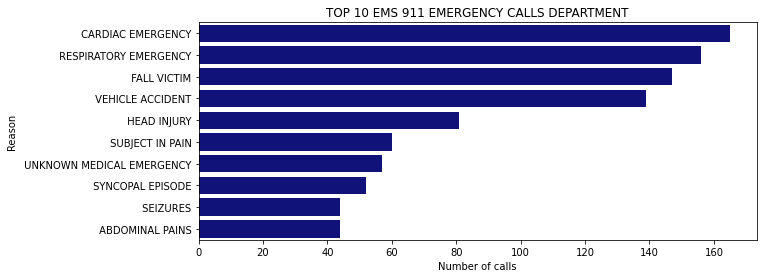

In [24]:
fig,ax=plt.subplots(figsize=(10,4))
sns.countplot(y='Reason',data=EMS,order=EMS['Reason'].value_counts().head(10).index, color='darkblue')
ax.set_xlabel('Number of calls')
plt.title('TOP 10 EMS 911 EMERGENCY CALLS DEPARTMENT')
plt.show()

**Observations**

* The most common emergency titles are fall victim, respiratory emergency and cardiac emergency.

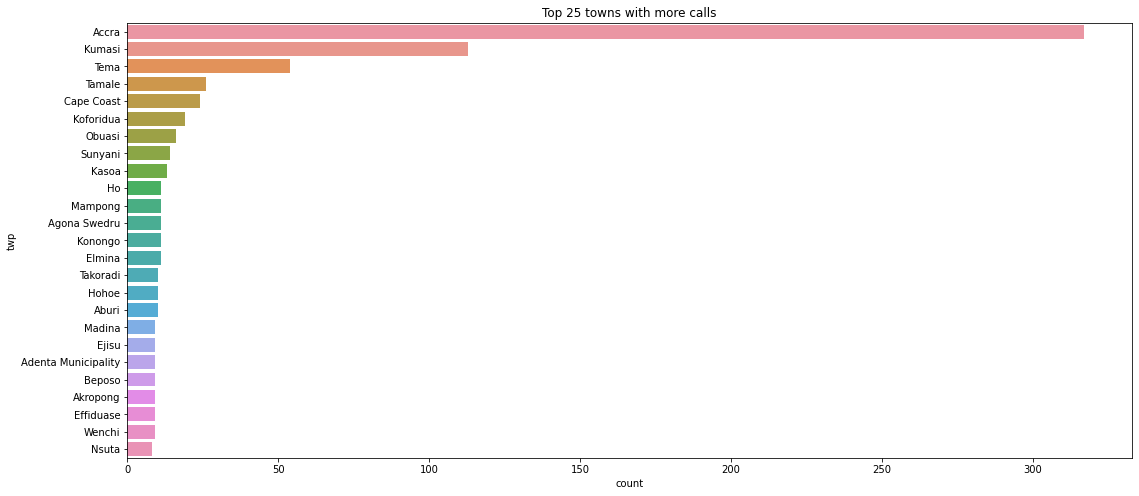

In [25]:
fig,ax=plt.subplots(figsize=(18,8))
sns.countplot(y='twp',data=dataset,order=dataset['twp'].value_counts().head(25).index)
plt.title('Top 25 towns with more calls')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


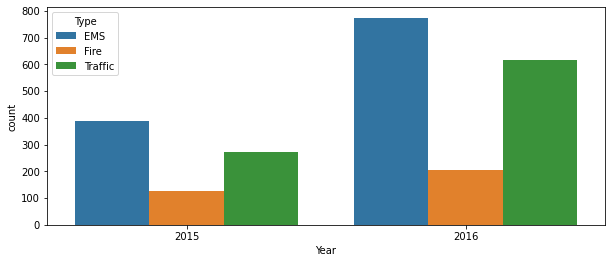

In [59]:
fig,ax=plt.subplots(figsize=(10,4))
sns.countplot('Year',data=dataset,hue='Type')
#plt.title('Top 25 towns with more calls')
plt.show()

**Observations**

* Emergency calls are almost same throughout the year, except for year 2015 and 2020.
* Our dataset contains data for only one month of year 2015 and only four months of year 2020. 
* So data is not available for complete year of 2015 and 2020.

 

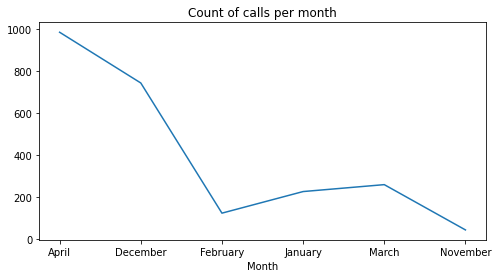

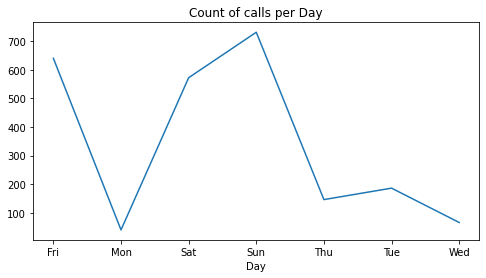

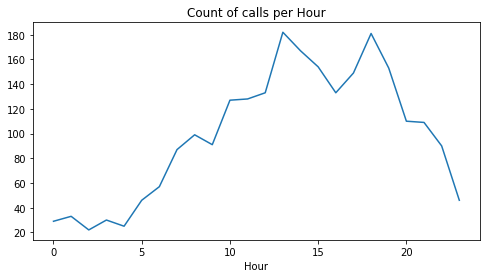

In [79]:
#month
byMonth = dataset.groupby('Month').count().sort_values(by='Month',ascending=True)
byMonth['twp'].plot(figsize=(8, 4))
plt.title('Count of calls per month')
plt.show()
#day
byDay = dataset.groupby('Day').count().sort_values(by='Day',ascending=True)
byDay['twp'].plot(figsize=(8, 4))
plt.title('Count of calls per Day')
plt.show()
#hour
byHour = dataset.groupby('Hour').count().sort_values(by='Hour',ascending=True)
byHour['twp'].plot(figsize=(8, 4))
plt.title('Count of calls per Hour')
plt.show()

**Observation**
* Maximum number of emergency calls happened at round 5PM.
* Maximum number of emergency calls happened on friday and minimum on sunday.
* Maximum emergency service required in the months of Jan,Feb, March and Dec.

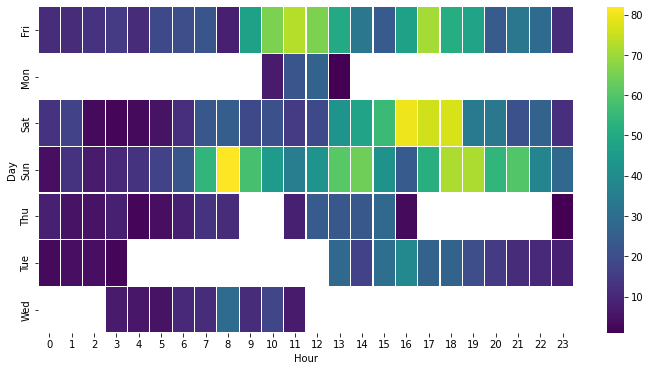

In [28]:
dayHour = dataset.groupby(['Day','Hour']).count()['Type'].unstack()
fig,ax=plt.subplots(figsize=(12,6))
sns.heatmap(dayHour,cmap='viridis',linewidths=.1)
plt.show()

**Observation**
* Less emergency service required at night or early morning,while more at evening time and that is even more on Friday.


In [29]:
latest=dataset[dataset['Year']==2020]

lat_traffic=traffic[traffic['Year']==2020]
lat_fire=fire[fire['Year']==2020]
lat_EMS=EMS[EMS['Year']==2020]

lat_fire.shape

(0, 15)

In [30]:
m = folium.Map(location=[7.9465,1.0232], tiles='cartodbpositron', zoom_start=7)

mc = MarkerCluster()
for idx, row in lat_traffic.iterrows():
    if not math.isnan(row['lng']) and not math.isnan(row['lat']):
        mc.add_child(Marker([row['lat'], row['lng']]))
m.add_child(mc)

m

#### Dealing With Missing Values

In [31]:
total=dataset.isnull().sum().sort_values(ascending=False)
percent=(dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
station_code,3031,0.999341
twp,643,0.212001
zip,10,0.003297
addr,1,0.000330
lat,0,0.000000
lng,0,0.000000
title,0,0.000000
timeStamp,0,0.000000
Hour,0,0.000000
Day,0,0.000000


In [32]:
dataset.dropna(subset=['twp'],inplace=True)

In [33]:
dataset.dropna(subset=['zip'],inplace=True)

In [34]:
total=dataset.isnull().sum().sort_values(ascending=False)
percent=(dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
station_code,2381,1.00000
addr,1,0.00042
lat,0,0.00000
lng,0,0.00000
zip,0,0.00000
title,0,0.00000
timeStamp,0,0.00000
twp,0,0.00000
Hour,0,0.00000
Day,0,0.00000


# Treating Outliers

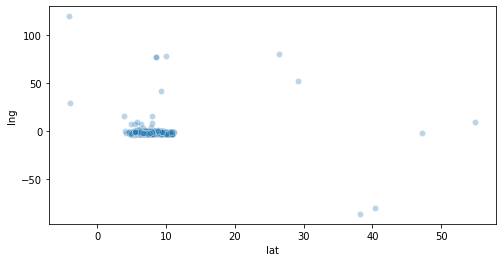

In [35]:
fig,ax = plt.subplots(figsize=(8,4))
sns.scatterplot(x='lat',y='lng',data=dataset, alpha=0.3)
plt.show()

Apparently there are some outliers. Let's use boxplot to do this analysis.

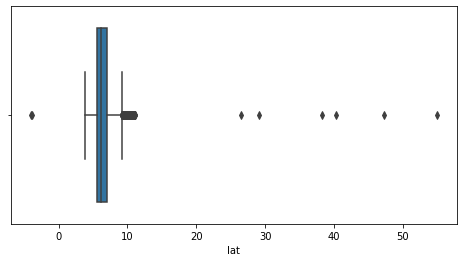

In [36]:
#Analysing Latitude
fig,ax = plt.subplots(figsize=(8,4))
sns.boxplot(x=dataset['lat'])
plt.show()

In [37]:
Q1=dataset['lat'].quantile(.25)
Q3=dataset['lat'].quantile(.75)
IQR=Q3-Q1
Lower_Whisker=Q1-1.5*IQR
Upper_Whisker = Q3+1.5*IQR

dataset_treated=dataset[(dataset['lat']<Upper_Whisker)&(dataset['lat']>Lower_Whisker)]

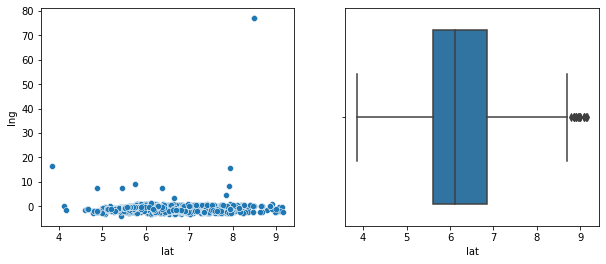

In [38]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
sns.scatterplot(x=dataset_treated['lat'],y=dataset_treated['lng'],data=dataset,ax=ax[0])
sns.boxplot(x=dataset_treated['lat'],ax=ax[1])
plt.show()

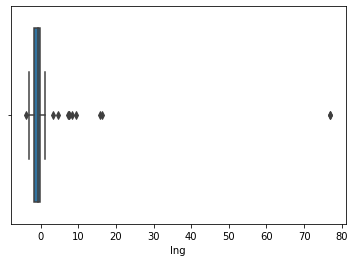

In [39]:
sns.boxplot(x=dataset_treated['lng'])

In [40]:
Q1=dataset_treated['lng'].quantile(.25)
Q3=dataset_treated['lng'].quantile(.75)
IQR=Q3-Q1
Lower_Whisker=Q1-1.5*IQR
Upper_Whisker = Q3+1.5*IQR
dataset_treated=dataset_treated[(dataset_treated['lng']<Upper_Whisker)&(dataset_treated['lng']>Lower_Whisker)]

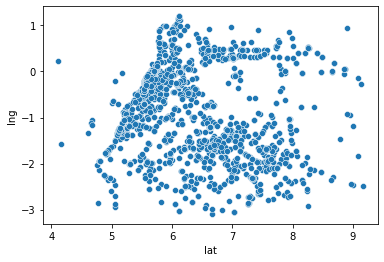

In [41]:
sns.scatterplot(x=dataset_treated['lat'],y=dataset_treated['lng'],data=dataset)

In [42]:
dataset_treated.shape

(2206, 15)


# **Association Rule Mining**
---






## **Preprocess Data for the** **Algorithm**

In [43]:
df=dataset_treated.drop(['station_code'], axis=1)

In [44]:
title_low=df["title"].value_counts()
sum=0
others=[]
for i in title_low.index:
    if(title_low[i]<=1000):
        sum=sum+title_low[i]
        others.append(i)
print(len(others))

def convert(x):
    if x in others:
        return "Others"
    else:
        return x
df.title = df.title.map(convert)

70


In [45]:
titles=df['title'].unique().tolist()
one_hot = pd.get_dummies(df['title'])
df.drop('title', inplace=True, axis=1)
df = df.join(one_hot)
df.head()

,lat,lng,zip,timeStamp,twp,addr,Hour,Day,Month,Year,Date,Type,Reason,Others
0,5.635828,-0.161359,233.0,2015-11-10 15:20:00,Accra,east legon,15,Tue,November,2015,2015-11-10,EMS,BACK PAINS/INJURY,1
1,5.644369,-0.185427,233.0,2015-11-10 17:35:00,Accra,vikings hostel,17,Tue,November,2015,2015-11-10,EMS,DIABETIC EMERGENCY,1
2,5.633940,-0.174082,233.0,2015-11-10 14:39:00,Accra,shiashie,14,Tue,November,2015,2015-11-10,Fire,GAS-ODOR/LEAK,1
3,5.651038,-0.135459,233.0,2015-11-10 16:47:00,Madina,adjiringanor,16,Tue,November,2015,2015-11-10,EMS,CARDIAC EMERGENCY,1
4,5.652202,-0.188107,233.0,2015-11-10 16:56:00,Accra,university of ghana computing systems,16,Tue,November,2015,2015-11-10,EMS,DIZZINESS,1


In [46]:
townships=df['twp'].unique().tolist()
one_hot = pd.get_dummies(df['twp'])
df.drop('twp', inplace=True, axis=1)
df = df.join(one_hot)
df.head()

,lat,lng,zip,timeStamp,addr,Hour,Day,Month,Year,Date,...,Wusuta,Yamfo,Yamoransa,Yefri,Zabrama,Ziope,kpeve,nungua,suhum,İnsu
0,5.635828,-0.161359,233.0,2015-11-10 15:20:00,east legon,15,Tue,November,2015,2015-11-10,...,0,0,0,0,0,0,0,0,0,0
1,5.644369,-0.185427,233.0,2015-11-10 17:35:00,vikings hostel,17,Tue,November,2015,2015-11-10,...,0,0,0,0,0,0,0,0,0,0
2,5.633940,-0.174082,233.0,2015-11-10 14:39:00,shiashie,14,Tue,November,2015,2015-11-10,...,0,0,0,0,0,0,0,0,0,0
3,5.651038,-0.135459,233.0,2015-11-10 16:47:00,adjiringanor,16,Tue,November,2015,2015-11-10,...,0,0,0,0,0,0,0,0,0,0
4,5.652202,-0.188107,233.0,2015-11-10 16:56:00,university of ghana computing systems,16,Tue,November,2015,2015-11-10,...,0,0,0,0,0,0,0,0,0,0


In [47]:
months=df['Month'].unique().tolist()
one_hot = pd.get_dummies(df['Month'])
df.drop('Month', inplace=True, axis=1)
df = df.join(one_hot)
df.head()

,lat,lng,zip,timeStamp,addr,Hour,Day,Year,Date,Type,...,kpeve,nungua,suhum,İnsu,April,December,February,January,March,November
0,5.635828,-0.161359,233.0,2015-11-10 15:20:00,east legon,15,Tue,2015,2015-11-10,EMS,...,0,0,0,0,0,0,0,0,0,1
1,5.644369,-0.185427,233.0,2015-11-10 17:35:00,vikings hostel,17,Tue,2015,2015-11-10,EMS,...,0,0,0,0,0,0,0,0,0,1
2,5.633940,-0.174082,233.0,2015-11-10 14:39:00,shiashie,14,Tue,2015,2015-11-10,Fire,...,0,0,0,0,0,0,0,0,0,1
3,5.651038,-0.135459,233.0,2015-11-10 16:47:00,adjiringanor,16,Tue,2015,2015-11-10,EMS,...,0,0,0,0,0,0,0,0,0,1
4,5.652202,-0.188107,233.0,2015-11-10 16:56:00,university of ghana computing systems,16,Tue,2015,2015-11-10,EMS,...,0,0,0,0,0,0,0,0,0,1


In [48]:
def convertHr(x):
    if x>=6 and x<12:
        return "Morning"
    elif x>=12 and x<16:
        return "Afternoon"
    elif x>=16 and x<21:
        return "Evening"
    else:
        return "Night"
df.Hour = df.Hour.map(convertHr)

In [49]:
times=df['Hour'].unique().tolist()
one_hot = pd.get_dummies(df['Hour'])
df.drop('Hour', inplace=True, axis=1)
df = df.join(one_hot)
df.head()

,lat,lng,zip,timeStamp,addr,Day,Year,Date,Type,Reason,...,April,December,February,January,March,November,Afternoon,Evening,Morning,Night
0,5.635828,-0.161359,233.0,2015-11-10 15:20:00,east legon,Tue,2015,2015-11-10,EMS,BACK PAINS/INJURY,...,0,0,0,0,0,1,1,0,0,0
1,5.644369,-0.185427,233.0,2015-11-10 17:35:00,vikings hostel,Tue,2015,2015-11-10,EMS,DIABETIC EMERGENCY,...,0,0,0,0,0,1,0,1,0,0
2,5.633940,-0.174082,233.0,2015-11-10 14:39:00,shiashie,Tue,2015,2015-11-10,Fire,GAS-ODOR/LEAK,...,0,0,0,0,0,1,1,0,0,0
3,5.651038,-0.135459,233.0,2015-11-10 16:47:00,adjiringanor,Tue,2015,2015-11-10,EMS,CARDIAC EMERGENCY,...,0,0,0,0,0,1,0,1,0,0
4,5.652202,-0.188107,233.0,2015-11-10 16:56:00,university of ghana computing systems,Tue,2015,2015-11-10,EMS,DIZZINESS,...,0,0,0,0,0,1,0,1,0,0


In [50]:
days=df['Day'].unique().tolist()
one_hot = pd.get_dummies(df['Day'])
df.drop('Day', inplace=True, axis=1)
df = df.join(one_hot)
df.head()

,lat,lng,zip,timeStamp,addr,Year,Date,Type,Reason,Others,...,Evening,Morning,Night,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,5.635828,-0.161359,233.0,2015-11-10 15:20:00,east legon,2015,2015-11-10,EMS,BACK PAINS/INJURY,1,...,0,0,0,0,0,0,0,0,1,0
1,5.644369,-0.185427,233.0,2015-11-10 17:35:00,vikings hostel,2015,2015-11-10,EMS,DIABETIC EMERGENCY,1,...,1,0,0,0,0,0,0,0,1,0
2,5.633940,-0.174082,233.0,2015-11-10 14:39:00,shiashie,2015,2015-11-10,Fire,GAS-ODOR/LEAK,1,...,0,0,0,0,0,0,0,0,1,0
3,5.651038,-0.135459,233.0,2015-11-10 16:47:00,adjiringanor,2015,2015-11-10,EMS,CARDIAC EMERGENCY,1,...,1,0,0,0,0,0,0,0,1,0
4,5.652202,-0.188107,233.0,2015-11-10 16:56:00,university of ghana computing systems,2015,2015-11-10,EMS,DIZZINESS,1,...,1,0,0,0,0,0,0,0,1,0


In [51]:
df=df.drop(['timeStamp', 'Type', 'zip','Reason'], axis=1)

In [52]:
df=df.drop(['lat','lng'], axis=1)

In [53]:
df_new=df.drop(['addr','Year','Date'], axis=1)

In [54]:
df_new.head()

,Others,A Medua,ABINGTON,Abakrampa,Abandze,Abawso,Abease,Abenase,Aberin,Abesim,...,Evening,Morning,Night,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


## **Apply** **Algorithm**

In [55]:
from mlxtend.frequent_patterns import apriori, association_rules

In [56]:
ap_0_5 = {}
ap_1 = {}
ap_5 = {}
ap_1_0 = {}

confidence = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

def gen_rules(df,confidence,support):
    ap = {}
    for i in confidence:
        ap_i =apriori(df_new,support,True)#, low_memory=True)
        rule= association_rules(ap_i,min_threshold=i)
        ap[i] = len(rule.antecedents)
    return pd.Series(ap).to_frame("Support: %s"%support)

confs = []
for i in [0.005,0.01,0.05,0.1]:
    ap_i = gen_rules(df_new,confidence=confidence,support=i)
    confs.append(ap_i)

all_conf = pd.concat(confs,axis=1)

/usr/local/lib/python3.7/dist-packages/mlxtend/frequent_patterns/fpcommon.py:115: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/mlxtend/frequent_patterns/fpcommon.py:115: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/mlxtend/frequent_patterns/fpcommon.py:115: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/mlxtend/frequent_patterns/fpcommon.py:115: DeprecationWarning: DataFrames with non-bool types res

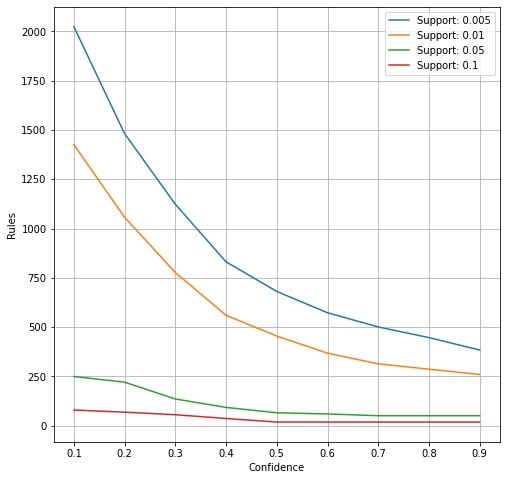

In [57]:
all_conf.plot(figsize=(8,8),grid=True)
plt.ylabel('Rules')
plt.xlabel('Confidence')
plt.show()

In [58]:
df_new.drop(['Traffic: VEHICLE ACCIDENT -'],axis=1,inplace=True)

KeyError: ignored

In [ ]:
import time

start_time=time.time()
frq_items = apriori(df_new, min_support = 0.005, use_colnames = True)#, low_memory=True) 
rules = association_rules(frq_items, metric ="lift", min_threshold = 0.03) 
end_time=time.time()
print("time elapsed", (end_time-start_time)/60)

rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules.head()) 

In [ ]:
final_rules=rules[rules['confidence'] > 0.1]

In [ ]:
final_rules.head(10)

### **Visualisation**

In [ ]:
def draw_graph(rules, rules_to_show):
  import networkx as nx
  G1 = nx.DiGraph()

  color_map = []
  N = 50
  colors = np.random.rand(N)
  strs=['R0','R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']

  for i in range(rules_to_show):
      G1.add_nodes_from(["R"+str(i)])

      for a in rules.iloc[i]['antecedents']:
          G1.add_nodes_from([a])
          G1.add_edge(a,"R"+str(i),color=colors[i],weight = 2)

      for c in rules.iloc[i]['consequents']:
          G1.add_nodes_from([c])
          G1.add_edge("R"+str(i),c,color=colors[i], weight = 2)
  for node in G1:
      found_a_string=False
      for item in strs:
          if node==item:
              found_a_string = True
      if found_a_string:
          color_map.append('yellow')
      else:
          color_map.append('green')

  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]

  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, node_color = color_map, edge_color = colors, width=weights, font_size=16, with_labels=False)

  for p in pos:
      pos[p][1] += 0.07
  nx.draw_networkx_labels(G1,pos)
  plt.show()




In [ ]:
support = rules['support'].values
confidence = rules['confidence'].values

import seaborn as sns1

plt.title('Association Rules')
plt.xlabel('support')
plt.ylabel('confidence')
sns1.regplot(x=support,y=confidence,fit_reg=False)

plt.gcf().clear()
draw_graph(rules,6)

FP Growth


In [ ]:
import itertools as it
from itertools import *

# help function
def partition(pred, iterable):
    t1, t2 = it.tee(iterable)
    return it.filterfalse(pred, t1), filter(pred, t2)

# divides list on all possible pairs
def part2(el_list):
    pairs = [[[x[1] for x in f] for f in partition(lambda x: x[0], zip(pattern, el_list))] \
     for pattern in product([True, False], repeat=len(el_list))]
    # remove pairs as [] -> [some content], [some content] -> []
    return pairs[1:-1]

In [ ]:
from mlxtend.frequent_patterns import fpgrowth
import time

start_time=time.time()
f_patterns = fpgrowth(df_new, min_support=0.005, use_colnames=True)
f_patterns
end_time=time.time()

# convert dataframe to dictionary
supports = f_patterns['support'].to_list()
itemsets = f_patterns['itemsets'].to_list()

patterns_dict = {}
for x in range(len(itemsets)):
    patterns_dict[tuple(sorted(itemsets[x]))] = supports[x]

# generate asssociation_rules
as_rules_dict = {'antecedents': [], 'consequents': [], 'confidence': [], 'support': []}
for pattern, support in patterns_dict.items():
    if len(pattern) > 1:
        upper_support = support
        as_rules = part2(pattern)
        
        for as_r in as_rules:
            left_part = sorted(as_r[0])
            right_part = as_r[1]
            lower_support = patterns_dict[tuple(left_part)]
            conf = upper_support / lower_support
            
            as_rules_dict['antecedents'].append(left_part)
            as_rules_dict['consequents'].append(right_part)
            as_rules_dict['confidence'].append(conf)
            as_rules_dict['support'].append(upper_support)
            
print("time elapsed", (end_time-start_time)/60)

strong_as_rules = pd.DataFrame.from_dict(as_rules_dict)
# sort by confidence, remove all rules with confidence lower than 0.8
strong_as_rules = strong_as_rules.sort_values('confidence', ascending=False)
strong_as_rules = strong_as_rules[strong_as_rules['confidence'] > 0.1]

In [ ]:
final_as_rules=strong_as_rules
for i in strong_as_rules.index:
    count=0
    count1=0
    for a in strong_as_rules['antecedents'][i]:
        if a in days+months+times:
            count=count+1
        if a in townships+days+months+times and strong_as_rules['consequents'][i][0] in townships+days+months+times:
            count1=count1+1
    if count==len(strong_as_rules['antecedents'][i]) or count==len(strong_as_rules['antecedents'][i]):
        final_as_rules.drop(i,inplace=True)

In [ ]:
support = final_as_rules['support'].values
confidence = final_as_rules['confidence'].values

for i in range (len(support)):
    support[i] = support[i]
    confidence[i] = confidence[i]

plt.title('Association Rules')
plt.xlabel('support')
plt.ylabel('confidence')
sns.regplot(x=support,y=confidence,fit_reg=False)

plt.gcf().clear()
draw_graph(final_as_rules,6)

### **Rule Cleaning**

Traffic Accidents


In [ ]:
list_col=[]
for col in df_new.columns:
  if(str(col)[:3] not in ['EMS', 'Fir', 'Oth', 'Tra']):
    list_col.append(str(col))
  if(str(col) in ['Traffic: VEHICLE ACCIDENT -']):
    list_col.append(str(col))

In [ ]:
df_Traffic=df_new.filter(list_col)

In [ ]:
frq_items = apriori(df_Traffic, min_support = 0.005, use_colnames = True,low_memory=True) 
rules_Traffic = association_rules(frq_items, metric ="lift", min_threshold = 0.03) 
rules_Traffic = rules_Traffic.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules_Traffic.head()) 

In [ ]:
support = rules_Traffic['support'].values
confidence = rules_Traffic['confidence'].values

import seaborn as sns1

plt.title('Association Rules')
plt.xlabel('support')
plt.ylabel('confidence')
sns1.regplot(x=support,y=confidence,fit_reg=False)

plt.gcf().clear()
draw_graph(rules_Traffic,6)

EMS

In [ ]:
list_col=[]
for col in df_new.columns:
  if(str(col)[:3] not in ['EMS', 'Fir', 'Oth', 'Tra']):
    list_col.append(str(col))
  if(str(col) in ['EMS: OVERDOSE']):
    list_col.append(str(col))

In [ ]:
df_EMS=df_new.filter(list_col)

In [ ]:
df_EMS.head()

In [ ]:
frq_items = apriori(df_EMS, min_support = 0.005, use_colnames = True,low_memory=True) 
rules_EMS = association_rules(frq_items, metric ="lift", min_threshold = 0.03) 
rules_EMS = rules_EMS.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules_EMS.head()) 

In [ ]:
support = rules_EMS['support'].values
confidence = rules_EMS['confidence'].values

import seaborn as sns1

plt.title('Association Rules')
plt.xlabel('support')
plt.ylabel('confidence')
sns1.regplot(x=support,y=confidence,fit_reg=False)

plt.gcf().clear()
draw_graph(rules_EMS,6)